In [1]:
import pandas as pd
import numpy as np
import math
import statistics
import datetime as dt
from matplotlib import pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored

from sksurv.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('imputed.csv')

#cleaning

categorical = ['ethnicity', 
              'marital_status',
              'language',
              'admission_location',
              'gender',
              'insurance',
              'first_careunit',
              'last_careunit',
              'admission_type']
proceduretype=['aortic','mit','tricuspid','pulmonary','cabg']
ptParams = ['weight', 'height']
boolFields = ['reintubation', 'liver_severe', 'liver_mild', 'rheum', 'cvd', 'aids', 'ckd', 'copd', 'arrhythmia', 'pud', 'smoking', 'pvd', 'paraplegia', 
              'ccf', 'met_ca', 't2dm', 't1dm', 'malig', 'mi', 'dementia', 'hospital_expire_flag', 'diab_un', 'diab_cc',]
deathInfo = ['dod', 'deathtime']
ptinfo = ['hadm_id', 'subject_id']
durations = ['duration1', 'duration2', 'icu_stay_duration', 'icu_stay_days']
timeFields =  ['admittime', 'dischtime', 'intime', 'outtime', 'ext_time', 
       'int_time1', 'ext_time1', 'int_time2', 'ext_time2']

tsColumns = [i for i in df.columns if '_max' in i or '_min' in i or '_mean' in i]
print([i for i in df.columns if i not in categorical + proceduretype + tsColumns + ptParams + boolFields + ptinfo + deathInfo + durations + timeFields])

for i in categorical:
    df[i] = df[i].astype('category')
    
df['icu_stay_days'] = [round(i/86400) for i in df['icu_stay_duration']]
df['icu_stay_duration'] /= 3600  # now icu_stay_duration
df = df[[i for i in df.columns if i not in ("Unnamed: 0", "0")]]
df['dod'] = df['dod'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d") if not pd.isnull(x) else np.NaN)
for i in timeFields:
    df[i] = df[i].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") if not pd.isnull(x) else np.NaN)
    
df = df[[i for i in df.columns if '_max' not in i and '_min' not in i]]
df = df[[i for i in df.columns if i not in ('last_careunit', 'infection_vent', 'icustay_seq', 'los')]]  # for some reason last_careunit messes up the Cox training

print(df.shape)
df

['Unnamed: 0', 'infection_vent', 'los', 'icustay_seq']
(9474, 91)


,temp_mean,hr_mean,spo2_mean,rr_mean,sbp_mean,dbp_mean,meanbp_mean,cardiac_index_mean,pt_mean,ptt_mean,inr_mean,inr_1_mean,fibrinogen_mean,hb_mean,hematocrit_mean,wcc_mean,lymphocytes_mean,neutrophils_mean,chloride_mean,magnesium_mean,potassium_mean,creatinine_mean,free_calcium_mean,sodium_mean,bicarb_mean,bun_mean,hba1c_mean,glucose_mean,lactate_mean,po2_mean,pco2_mean,baseexcess_mean,ph_mean,insulin_mean,prbc_mean,plt_mean,gender,ethnicity,marital_status,insurance,language,aortic,mit,tricuspid,pulmonary,cabg,weight,height,reintubation,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,first_careunit,admission_location,admission_type,hospital_expire_flag,diab_un,diab_cc,icu_stay_duration,admittime,dischtime,intime,outtime,ext_time,deathtime,hadm_id,subject_id,int_time1,ext_time1,duration1,int_time2,ext_time2,duration2,dod,icu_stay_days
0,37.145834,89.393939,97.967742,24.382353,115.666667,60.515152,75.712121,2.759261,14.450000,29.80,1.200,1.200,527.0,12.050000,35.000000,13.900000,17.1,80.1,104.500000,1.80,3.666667,0.80,1.150000,138.000000,25.5,12.0,6.4,124.875000,1.657143,0.500000,41.000000,0.500000,7.400000,335.333333,843.750000,261.500000,M,white,SINGLE,Private,ENGL,0,0,0,0,1,84.00,172.72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,CSRU,PHYSICIAN REFERRAL,ELECTIVE,0,0,0,50.110833,2198-01-31 08:00:00,2198-02-04 12:00:00,2198-01-31 12:27:58,2198-02-02 19:06:39,2198-01-31 22:00:00,NaN,195663,27328,2198-01-31 17:00:00,2198-01-31 22:00:00,5.000000,NaT,NaT,NaN,NaT,2
1,37.023530,92.277778,97.276316,12.807692,98.000000,53.222222,67.861111,2.222764,17.350000,42.80,1.600,1.600,188.5,7.320000,22.000000,19.566667,8.3,80.1,108.000000,2.10,4.375000,0.60,1.128000,142.000000,26.0,12.0,6.3,145.562500,1.400000,0.818182,42.818182,0.818182,7.398182,262.500000,375.000000,122.500000,F,other,DIVORCED,Self Pay,SPAN,1,0,0,0,0,60.00,170.18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,CSRU,PHYSICIAN REFERRAL,ELECTIVE,0,0,0,50.766667,2198-05-08 07:15:00,2198-05-15 13:49:00,2198-05-08 13:14:00,2198-05-10 19:46:00,2198-05-09 09:29:00,NaN,106984,6280,2198-05-08 17:00:00,2198-05-09 09:29:00,16.483333,NaT,NaT,NaN,NaT,2
2,36.883784,85.027027,99.636364,15.342105,121.000000,58.459459,80.108108,2.108540,17.633333,59.30,1.600,1.600,138.0,10.060000,28.000000,21.850000,12.2,84.8,111.000000,2.60,4.285714,1.20,1.156000,140.333333,26.5,19.0,9.9,120.629630,1.400000,1.166667,41.333333,1.166667,7.404286,170.000000,375.000000,144.500000,F,asian,MARRIED,Medicare,CANT,1,0,0,0,1,57.00,165.10,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,CSRU,PHYSICIAN REFERRAL,ELECTIVE,0,0,0,48.630000,2189-02-18 08:00:00,2189-03-17 14:20:00,2189-02-18 10:51:08,2189-02-20 13:37:48,2189-02-19 09:00:00,NaN,123613,15201,2189-02-18 13:00:00,2189-02-19 09:00:00,20.000000,NaT,NaT,NaN,2191-12-14,2
3,37.532258,87.939394,97.531250,16.212121,113.191176,56.823529,73.575758,2.899448,13.800000,28.30,1.200,1.200,230.0,13.800000,40.166667,14.000000,8.1,88.0,106.000000,1.85,3.800000,0.55,1.125000,139.000000,27.5,12.5,5.6,126.533333,1.785714,0.625000,45.750000,0.625000,7.377778,229.666667,1184.000000,161.000000,M,other,MARRIED,Private,PTUN,0,0,0,0,1,135.00,190.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CSRU,PHYSICIAN REFERRAL,ELECTIVE,0,1,0,23.550556,2118-01-25 07:15:00,2118-01-29 13:00:00,2118-01-25 10:46:42,2118-01-26 12:33:02,2118-01-25 17:30:00,NaN,126027,25226,2118-01-25 13:00:00,2118-01-25 17:30:00,4.500000,NaT,NaT,NaN,NaT,1
4,36.880362,87.240000,99.083333,13.397959,113.440000,63.810000,79.446667,2.386696,13.200000,30.50,1.175,1.175,377.0,9.812500,30.000000,11.600000,15.0,61.0,108.000000,3.60,4.420000,1.20,1.027500,137.000000,23.0,16.0,6.4,134.230769,1.500000,-3.000000,44.600000,-3.000000,7.318000,162.666667,187.500000,95.000000,M,white,MARRIED,Medicare,HIND,1,0,0,0,0,70.00,175.26,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,CSRU,PHYSICIAN REFERRAL,ELECTIVE,0,1,0,47.000000,2198-01-01 07:15:00,2198-01-09 13:07:00,2198-01-01 10:47:00,2198-01-03 12:00:

In [3]:
# target variable: icu stay duration
data_y = np.array([(True, df['icu_stay_duration'][i]) for i in range(df.shape[0])], dtype=[('Status', '?'), ('Stay_in_hrs', '<f8')])
data_y

array([( True,  50.11083333), ( True,  50.76666667),
       ( True,  48.63      ), ..., ( True,  25.16416667),
       ( True, 142.52277778), ( True,  22.29111111)],
      dtype=[('Status', '?'), ('Stay_in_hrs', '<f8')])

Text(0.5, 0, 'time $t$')

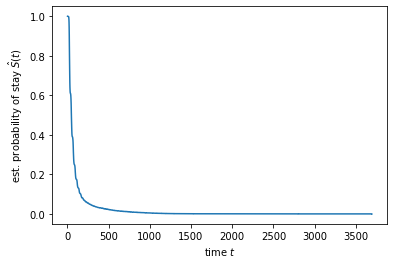

In [4]:
%matplotlib inline

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Stay_in_hrs"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of stay $\hat{S}(t)$")
plt.xlabel("time $t$")

In [5]:
# one hot encodes categorical variables and removes columns related to irrelevant stuff
data_x = df[[i for i in df.columns if i not in durations + ptinfo + deathInfo + timeFields]]
print(data_x.columns)

Index(['temp_mean', 'hr_mean', 'spo2_mean', 'rr_mean', 'sbp_mean', 'dbp_mean',
       'meanbp_mean', 'cardiac_index_mean', 'pt_mean', 'ptt_mean', 'inr_mean',
       'inr_1_mean', 'fibrinogen_mean', 'hb_mean', 'hematocrit_mean',
       'wcc_mean', 'lymphocytes_mean', 'neutrophils_mean', 'chloride_mean',
       'magnesium_mean', 'potassium_mean', 'creatinine_mean',
       'free_calcium_mean', 'sodium_mean', 'bicarb_mean', 'bun_mean',
       'hba1c_mean', 'glucose_mean', 'lactate_mean', 'po2_mean', 'pco2_mean',
       'baseexcess_mean', 'ph_mean', 'insulin_mean', 'prbc_mean', 'plt_mean',
       'gender', 'ethnicity', 'marital_status', 'insurance', 'language',
       'aortic', 'mit', 'tricuspid', 'pulmonary', 'cabg', 'weight', 'height',
       'reintubation', 'liver_severe', 'liver_mild', 'rheum', 'cvd', 'aids',
       'ckd', 'copd', 'arrhythmia', 'pud', 'smoking', 'pvd', 'paraplegia',
       'ccf', 'met_ca', 't2dm', 't1dm', 'malig', 'mi', 'dementia',
       'first_careunit', 'admission_lo

In [6]:
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric

,temp_mean,hr_mean,spo2_mean,rr_mean,sbp_mean,dbp_mean,meanbp_mean,cardiac_index_mean,pt_mean,ptt_mean,inr_mean,inr_1_mean,fibrinogen_mean,hb_mean,hematocrit_mean,wcc_mean,lymphocytes_mean,neutrophils_mean,chloride_mean,magnesium_mean,potassium_mean,creatinine_mean,free_calcium_mean,sodium_mean,bicarb_mean,bun_mean,hba1c_mean,glucose_mean,lactate_mean,po2_mean,pco2_mean,baseexcess_mean,ph_mean,insulin_mean,prbc_mean,plt_mean,gender=M,ethnicity=black,ethnicity=hispanic,ethnicity=native,ethnicity=other,ethnicity=white,marital_status=MARRIED,marital_status=SEPARATED,marital_status=SINGLE,marital_status=WIDOWED,insurance=Medicaid,insurance=Medicare,insurance=Other,insurance=Private,insurance=Self Pay,language=*GUJ,language=*LEB,language=ALBA,language=AMER,language=ARAB,language=CAMB,language=CANT,language=CAPE,language=ENGL,language=ETHI,language=GERM,language=GREE,language=HAIT,language=HIND,language=ITAL,language=KORE,language=MAND,language=PERS,language=POLI,language=PORT,language=PTUN,language=RUSS,language=SPAN,language=THAI,language=TURK,language=URDU,language=VIET,aortic,mit,tricuspid,pulmonary,cabg,weight,height,reintubation,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,first_careunit=CSRU,first_careunit=CVICU,first_careunit=MICU,first_careunit=MICU/SICU,first_careunit=Neuro Inter,first_careunit=Neuro SICU,first_careunit=SICU,first_careunit=TSICU,admission_location=CLINIC REFERRAL/PREMATURE,admission_location=EMERGENCY ROOM,admission_location=INTERNAL TRANSFER TO OR FROM PSYCH,admission_location=PACU,admission_location=PHYSICIAN REFERRAL,admission_location=PROCEDURE SITE,admission_location=TRANSFER FROM HOSPITAL,admission_location=TRANSFER FROM OTHER HEALT,admission_location=TRANSFER FROM SKILLED NURSING FACILITY,admission_location=WALK-IN/SELF REFERRAL,admission_type=ELECTIVE,admission_type=EMERGENCY,admission_type=EW EMER.,admission_type=OBSERVATION ADMIT,admission_type=SURGICAL SAME DAY ADMISSION,admission_type=URGENT,hospital_expire_flag,diab_un,diab_cc
0,37.145834,89.393939,97.967742,24.382353,115.666667,60.515152,75.712121,2.759261,14.450000,29.80,1.200,1.200,527.0,12.050000,35.000000,13.900000,17.1,80.1,104.500000,1.80,3.666667,0.80,1.150000,138.000000,25.5,12.0,6.4,124.875000,1.657143,0.500000,41.000000,0.500000,7.400000,335.333333,843.750000,261.500000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,84.00,172.72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,37.023530,92.277778,97.276316,12.807692,98.000000,53.222222,67.861111,2.222764,17.350000,42.80,1.600,1.600,188.5,7.320000,22.000000,19.566667,8.3,80.1,108.000000,2.10,4.375000,0.60,1.128000,142.000000,26.0,12.0,6.3,145.562500,1.400000,0.818182,42.818182,0.818182,7.398182,262.500000,375.000000,122.500000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,60.00,170.18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,36.883784,85.027027,99.636364,15.342105,121.000000,58.459459,80.108108,2.108540,17.633333,59.30,1.600,1.600,138.0,10.060000,28.000000,21.850000,12.2,84.8,111.000000,2.60,4.285714,1.20,1.156000,140.333333,26.5,19.0,9.9,120.629630,1.400000,1.166667,41.333333,1.166667,7.404286,170.000000,375.000000,144.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,57.00,165.10,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0

In [7]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)
# estimator.fit(data_x_numeric[data_x_numeric.columns[:115]], data_y)

CoxPHSurvivalAnalysis()

In [8]:
# get concordance index of trained estimator
prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["Status"], data_y["Stay_in_hrs"], prediction)
result[0]

0.6974505250663764

In [9]:
# which variables are predictive?
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, data_y)

In [10]:
pd.set_option('display.max_rows', None)
print(pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False))
pd.reset_option('display.max_rows')

ccf                                                          0.573490
bun_mean                                                     0.571896
creatinine_mean                                              0.567701
ptt_mean                                                     0.566654
arrhythmia                                                   0.559154
reintubation                                                 0.554741
pt_mean                                                      0.552647
bicarb_mean                                                  0.551544
inr_1_mean                                                   0.551013
dbp_mean                                                     0.550977
inr_mean                                                     0.550964
po2_mean                                                     0.549071
sbp_mean                                                     0.547218
hb_mean                                                      0.545214
meanbp_mean         

In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=100)
)
warnings.simplefilter("ignore", ConvergenceWarning)
coxnet_pipe.fit(data_x_numeric,data_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.001, l1_ratio=0.9,
                                        max_iter=100))])

In [12]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(data_x_numeric, data_y)

cv_results = pd.DataFrame(gcv.cv_results_)

In [13]:
cv_results.to_csv('cvresultscox.csv')

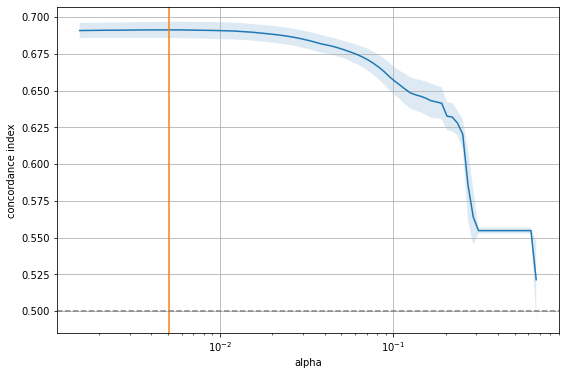

In [14]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)